# Part 1
Crisis logger is text data from online surveys. Each row has a upload id related to the session created at the time of logging their response to covid question. The KeyBert model is applied on it to extract the key phrases from the 132 participant sessions. 

In [1]:
import pandas as pd

root = "C:\\Users\\user\\SadafPythonCode\\MLHackathon\\ML-for-Good-Hackathon\\Data\\"
df = pd.read_csv(root + 'CrisisLogger\\crisislogger.csv')

#duplicated ids are joined in one transcription e.g. 436 and 441 are duplicate ids
df = df.groupby(['upload_id'])['transcriptions'].apply(' '.join).reset_index()
df.head()

,upload_id,transcriptions
0,10,so high our experience so far has been a littl...
1,209,I'm not going to stay in my name for the anony...
2,216,so far I have been florentines now for about a...
3,222,it has actually been a very difficult. Trying ...
4,228,so this whole situation has been strange for u...


In [2]:
from keybert import KeyBERT

mydoc = '. '.join([elem for elem in df.transcriptions])

kw_model = KeyBERT()
keywords = kw_model.extract_keywords(mydoc,
                                     keyphrase_ngram_range=(3,3), 
                                     use_mmr=True,
                                     diversity=0.2                                    
                                    )
keywords

[('parent working home', 0.5365),
 ('daughter taking isolation', 0.529),
 ('difficult home teenage', 0.4776),
 ('working home difficult', 0.4858),
 ('able homeschool daughter', 0.45)]

The main themes gathered are parents working from home, teenagers have been challenging during this time along with challenging work environments. 

### Word Cloud

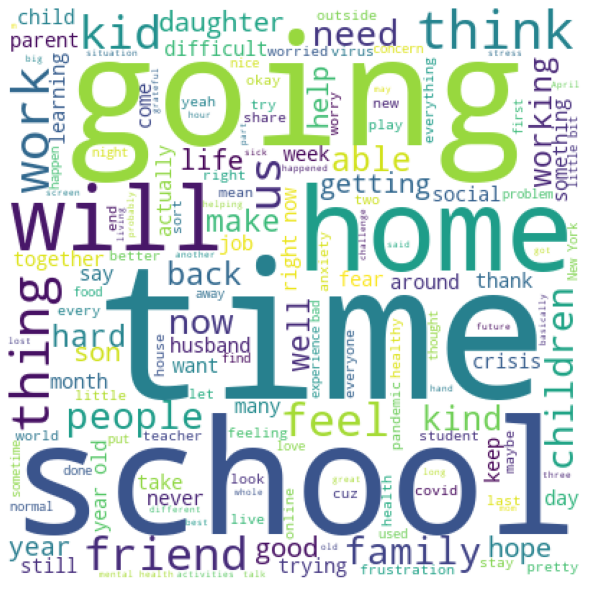

In [3]:
from wordcloud import WordCloud

corpus=''
for i in range(len(df)):
    corpus += "".join(df.iloc[i]['transcriptions'])

from collections import Counter
swords = ['know', 'like', 'get', 'one', 'much', 'also', 'even', 'u', 'lot', 'even', 'one', 'go', 'way', 'day', 'see', 'really']

word_list = corpus.split(' ')
resultwords = [word for word in word_list if word not in swords]
result = ' '.join(resultwords)

new_list = result.split(' ')
Counter = Counter(new_list)
most_occur = Counter.most_common(30)
most_occur

wordcloud = WordCloud(width=400, height=400, background_color='white', min_font_size=6).generate(result)

import matplotlib.pyplot as plt
plt.figure(figsize = (8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

# Part 2: Focus Groups

#### Helper functions

In [4]:
from docx import Document
import text2emotion as te
import numpy as np
import matplotlib.pyplot as plt

plist = []
mlist = []
d={}

def getText(filename):
    plist = []
    mlist = []
    d={}
    doc = Document(filename)
    fullText = []
    for para in doc.paragraphs:
        #remove text within brackets
        new_para = re.sub(r"\([^()]*\)", "", para.text) 
        new_para = re.sub(r"\[[^()]*\]", "", new_para)
        
        if len(new_para):
            if new_para.endswith(':'):
                lastspkr = new_para[:-1]
                if lastspkr not in d:                
                    d[lastspkr]= []
                
                if new_para.startswith('P'):
                    plist.append(new_para[:-1])
                else:
                    mlist.append(new_para[:-1])
            else:
                if len(new_para) > 2:
                    d[lastspkr].append(str(new_para))
    return d, set(plist), set(mlist)
                

def getparent(dret, p):
    script = []
    for parent in p:
        script.extend(dret[parent])
    return script

def process_doc(ngrp, grpname):
    script = []
    print("process_doc(): {} group".format(grpname))
    for i in range(1, ngrp+1):        
        fpath = root + 'FocusGroups\\'+grpname+'_Group{}.docx'.format(i)
        dret, p, m = getText(fpath)
        print(fpath)
        script.extend(getparent(dret, p))
    
    df = pd.DataFrame(script, columns=['text'])
    df_clean = clean_all(df, 'text')
    return df_clean

def get_keywords(df):
    kw = []
    for i in range(len(df.text.to_list())):
        keywords = kw_model.extract_keywords(df.text.to_list()[i],
                                             keyphrase_ngram_range=(3,3), 
                                             #use_maxsum = True,
                                             stop_words='english',
                                             use_mmr=True,
                                             diversity=0.2,
                                             top_n = 8,
                                             min_df = 3,
                                             #seed_keywords = ['youtube', 'computer', 'game',  'screen']
                                            )

        if keywords:
            kw.extend(keywords)

    df_kw = pd.DataFrame(kw, columns=['keyConcerns', 'csumprob'])
    df_kw_grp = df_kw.groupby('keyConcerns').sum().sort_values(by='csumprob', ascending=False)

    #df_kw_grp = df_kw_grp[df_kw_grp['csumprob'] > 1]
    df_kw_grp = df_kw_grp.iloc[0:8]
    df_kw_grp.plot(kind='bar', title='Gaming Group', ylabel='Importance',
             xlabel='Top Concerns', figsize=(6, 5))

def get_sentiment_percentage(df):
    h = df['Happy'].sum()
    a = df['Angry'].sum()
    sr = df['Surprise'].sum()
    sd = df['Sad'].sum()
    f = df['Fear'].sum()
    
    total = (h+a+sr+sd+f)
    return round(h/total*100), round(a/total*100), round(sr/total*100), round(sd/total*100), round(f/total*100)

sentiment = ['happy', 'angry' , 'surprise', 'sad', 'fear']
y_pos = range(len(sentiment))
def get_grp_sentiment(df):
    df['emotion'] = df.apply(lambda row: te.get_emotion(row.text), axis=1)
    df = pd.concat([df.drop(['emotion'], axis=1), df['emotion'].apply(pd.Series)], axis=1)
    a = get_sentiment_percentage(df)

    fig, ax = plt.subplots()
    ax.barh(y_pos, a, align='center')
    ax.set_yticks(y_pos, labels=sentiment)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Percentage')
    ax.set_title('Sentiment Percentage Analysis')
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# packages
import spacy
import nltk
import re
import pandas as pd


nlp = spacy.load('en_core_web_sm')
STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}


def clean_all(df, col_name):
    """
    Combines all functions used to clean and lemmatize the comments.
    :param df: data frame with comments
    :param col_name: column name in data frame containing comments
    :return: data frame with comments column lemmatized
    """

    # encode for only ascii characters
    df[col_name] = df[col_name].map(ascii_rm)
    
    # lowercase texts
    df[col_name] = df[col_name].map(lambda x: x.lower())


    # lemmatize words
    df[col_name] = df[col_name].astype(str).map(lemma)

    # remove punctuation
    df[col_name] = df[col_name].map(punc_n)


    # filter only english comments/non blank comments
    df['language'] = df[col_name].map(get_language)
    df = df.loc[df['language'] == 'english']
    df = df.drop('language', axis=1)
    df = df[df[col_name] != ""]
    
    return df


def ascii_rm(comment):
    """
    Parses comments and keep only ascii characters
    :param comment: a comment
    :return: comment with only ascii characters
    """
    comment = comment.encode('ascii', errors = 'ignore')
    return comment

def get_language(text):
    """
    Determines what language the comment is written in and filters only English comments.
    :param text: comment
    :return: language of comment
    """
    words = set(nltk.wordpunct_tokenize(text.lower()))
    return max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]


def punc_n(comment):
    """
    Removes punctuations from comments.
    :param comment: a comment
    :return: comment without punctuations
    """
    regex = re.compile('[' + re.escape('!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~')+'0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", comment)
    nopunct_words = nopunct.split(' ')
    filter_words = [word.strip() for word in nopunct_words if word != '']
    words = ' '.join(filter_words)
    return words



def lemma(comment):
    """
    Lemmatize comments using spacy lemmatizer.
    :param comment: a comment
    :return: lemmatized comment
    """
    lemmatized = nlp(comment)
    lemmatized_final = ' '.join([word.lemma_ for word in lemmatized if word.lemma_ != '\'s'])
    return lemmatized_final


### High Probability Internet User Groups
##### 1. Gaming Group KeyConcerns

process_doc(): Gaming group
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Gaming_Group1.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Gaming_Group2.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Gaming_Group3.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Gaming_Group4.docx


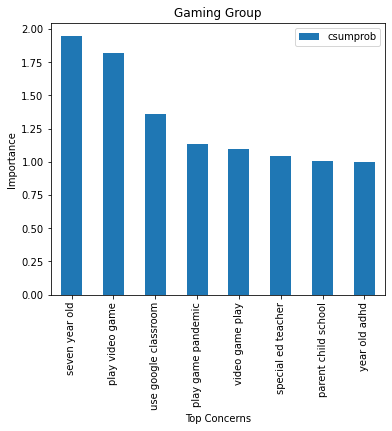

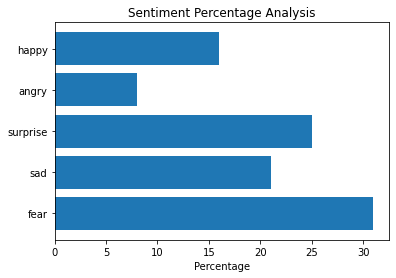

In [6]:
df_gaming = process_doc(4, 'Gaming')
get_keywords(df_gaming)
get_grp_sentiment(df_gaming)

##### 2. Media Group Key Concerns

process_doc(): Media group
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Media_Group1.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Media_Group2.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Media_Group3.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Media_Group4.docx


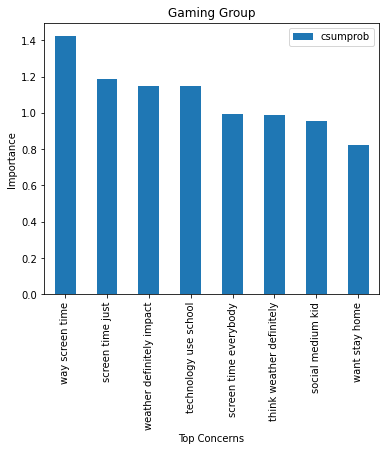

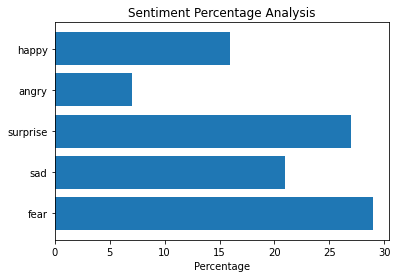

In [7]:
df_media = process_doc(4, 'Media')
get_keywords(df_media)
get_grp_sentiment(df_media)

##### 3. Social Group Key Concerns

process_doc(): Social group
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Social_Group1.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Social_Group2.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Social_Group3.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\Social_Group4.docx


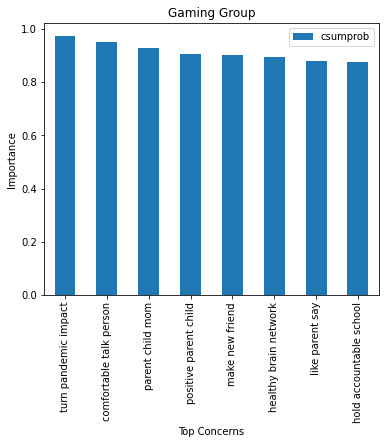

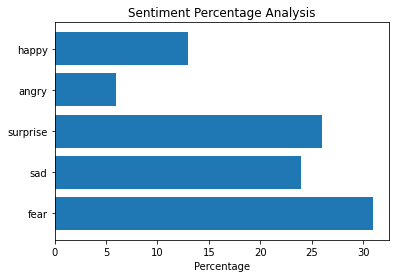

In [8]:
df_social = process_doc(4, 'Social')
get_keywords(df_social)
get_grp_sentiment(df_social)

#### Topic Modeling on High Internet Usage Parent Groups

In [13]:
df_hiu = pd.concat([df_gaming, df_media, df_social])
df_hiu.shape

Index(['text', 'emotion'], dtype='object')

In [29]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model = BERTopic(embedding_model="all-mpnet-base-v2",
                       vectorizer_model=vectorizer_model,
                       n_gram_range=(2,3),                        
                      )

docs = df_hiu.text.to_list()
topic_model.fit(docs)

In [30]:
topic_model.visualize_topics()

In [31]:
topic_model.visualize_barchart()

### Low Probability Internet Usage (PIU) Group

process_doc(): LowPIU group
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\LowPIU_Group1.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\LowPIU_Group2.docx
C:\Users\user\SadafPythonCode\MLHackathon\ML-for-Good-Hackathon\Data\FocusGroups\LowPIU_Group3.docx


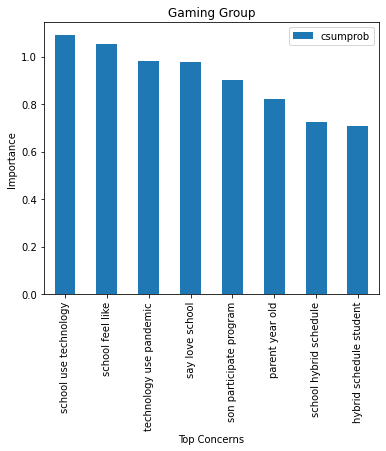

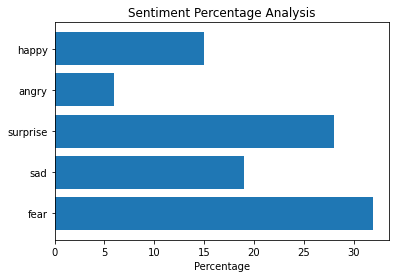

In [32]:
df_lowpiu = process_doc(3, 'LowPIU')
get_keywords(df_lowpiu)
get_grp_sentiment(df_lowpiu)

# Part 3: Prolific Academic Survey DataFocus Groups

In [33]:
df_p1 = pd.read_csv(root + 'ProlificAcademic\\April 2020\\Data\\CRISIS_Parent_April_2020.csv')
df_p2 = pd.read_csv(root + 'ProlificAcademic\\May 2020\\Data\\CRISIS_Parent_May_2020.csv')
df_p3 = pd.read_csv(root + 'ProlificAcademic\\November 2020\\Data\\CRISIS_Parent_November_2020.csv')
df_p4 = pd.read_csv(root + 'ProlificAcademic\\April 2021\\Data\\CRISIS_Parent_April_2021.csv')

In [34]:
df_pos_1 = df_p1[['timestamp1', 'specifypositive']].dropna()
df_pos_2 = df_p2[['timestamp1', 'specifypositive']].dropna()
df_pos_3 = df_p3[['timestamp1', 'specifypositive']].dropna()
df_pos_4 = df_p4[['timestamp1', 'specifypositive']].dropna()

df_combined = pd.concat([df_pos_1, df_pos_2, df_pos_3, df_pos_4])

In [35]:
positive_things = df_combined.specifypositive.to_list()
dates = df_combined['timestamp1'].apply(lambda x: pd.Timestamp(x)).to_list()

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words="english")
topic_model = BERTopic(vectorizer_model=vectorizer_model,
                       #min_topic_size=70,
                       n_gram_range=(1,2),
                       verbose=True)
topics, _ = topic_model.fit_transform(positive_things)

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

2021-12-03 15:14:21,248 - BERTopic - Transformed documents to Embeddings
2021-12-03 15:14:32,898 - BERTopic - Reduced dimensionality with UMAP
2021-12-03 15:14:33,028 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [36]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,550,-1_closer_house_quality time_job
1,0,260,0_enjoys_enjoying_things enjoys_daughter
2,1,189,1_activities family_nights family_family game_...
3,2,124,2_school closed_school work_private school_onl...
4,3,118,3_family times_famiky time_time famiky_time fa...
...,...,...,...
76,75,11,75_time families_lot family_families spending_...
77,76,11,76_friends_friends video_friends online_friend...
78,77,11,77_time mom_mom time_time mother_mother time
79,78,11,78_family spent_spent time_hobby spent_priorit...


In [37]:
topic_model.visualize_topics()

In [38]:
topics_over_time = topic_model.topics_over_time(positive_things, topics, dates,  nr_bins=40)
topic_model.visualize_topics_over_time(topics_over_time)

9it [00:18,  2.01s/it]


In [40]:
topic_model.get_topic(0)

[('enjoys', 0.012470658821767809),
 ('enjoying', 0.009546572785060905),
 ('things enjoys', 0.007469584145955454),
 ('daughter', 0.007212803210850964),
 ('home school', 0.006145282628659517),
 ('home parents', 0.005622650247198409),
 ('homeschooled', 0.005597192749131611),
 ('home shes', 0.005481691328635315),
 ('stay home', 0.00523379435147832),
 ('shes enjoying', 0.005205438092715525)]

In [42]:
topic_model.get_topic(3)

[('family times', 0.012138059565396797),
 ('famiky time', 0.012138059565396797),
 ('time famiky', 0.012138059565396797),
 ('time familu', 0.012138059565396797),
 ('familu time', 0.012138059565396797),
 ('times family', 0.012138059565396797),
 ('entire family', 0.010690988207234072),
 ('family lots', 0.010690988207234072),
 ('times', 0.008075616665490089),
 ('family members', 0.0056849437963815246)]

The blue line Topic 0 indicates the topic where most of the words relate to the enjoyment of the lock down. From the plot it is seen that in the beginning of the lockdown April 2020, this factor peaked off whereas it gradually decreased as the families became used to of the new routine being at home all the time. Same goes for the topic 3 since excessive family time has been a welcome change in the initial days but till November 2020 this this element is not that frequent. i.e. its importance dropped with time. 